In [20]:
import os, random, time, re, io, requests, json, math, warnings
import numpy as np
import pandas as pd
import torch
from contextlib import contextmanager

warnings.filterwarnings("ignore")

# === CONFIG ===
PROJECT_ROOT = os.path.abspath(os.path.join(".."))
DATA_CSV     = os.path.join(PROJECT_ROOT, "data", "products.csv")
FAISS_DIR    = os.path.join(PROJECT_ROOT, "models", "faiss", "sbert_faiss")
SEED         = 42
CPU_ONLY     = True  # run on CPU for portability

# === REPRODUCIBILITY ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if CPU_ONLY:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

@contextmanager
def stopwatch(msg: str):
    t0 = time.time()
    yield
    print(f"[time] {msg}: {(time.time()-t0):.2f}s")

pd.set_option("display.max_colwidth", 200)


In [21]:
assert os.path.exists(DATA_CSV), f"CSV not found at {DATA_CSV}"
df = pd.read_csv(DATA_CSV).fillna("")
print("Raw shape:", df.shape)

# Basic cleanup
def norm_text(s):
    s = str(s)
    s = s.replace("\n", " ").strip()
    s = re.sub(r"\s+", " ", s)
    return s

for col in ["title", "brand", "description", "material", "color", "categories", "images"]:
    if col in df.columns:
        df[col] = df[col].map(norm_text)

def first_cat(s):
    parts = [p.strip() for p in str(s).split(",") if p.strip()]
    return parts[0] if parts else ""

def first_img(s):
    return str(s).split(",")[0].strip() if str(s).strip() else ""

def parse_price(x):
    s = re.sub(r"[^\d.\-]", "", str(x))
    try: return float(s)
    except: return np.nan

df["category_main"] = df.get("categories", "").map(first_cat)
df["image_0"]       = df.get("images", "").map(first_img)
df["price_num"]     = df.get("price", "").map(parse_price)

def coalesce(*vals):
    return " ".join([v for v in map(str, vals) if v and v.strip()])

df["doc"] = df.apply(lambda r: coalesce(
    r.get("title",""), r.get("brand",""), r.get("description",""),
    r.get("material",""), r.get("color","")
), axis=1)

print("Cleaned shape:", df.shape)
df[["uniq_id","title","category_main","price_num"]].head(5)


Raw shape: (312, 12)
Cleaned shape: (312, 16)


,uniq_id,title,category_main,price_num
0,02593e81-5c09-5069-8516-b0b29f439ded,"GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Metal Shoe Cap Rack With 8 Double Hooks For Living Room, Bathroom, Hallway",['Home & Kitchen',24.99
1,5938d217-b8c5-5d3e-b1cf-e28e340f292e,"subrtex Leather ding Room, Dining Chairs Set of 2, Black",['Home & Kitchen',NaN
2,b2ede786-3f51-5a45-9a5b-bcf856958cd8,"Plant Repotting Mat MUYETOL Waterproof Transplanting Mat Indoor 26.8"" x 26.8"" Portable Square Foldable Easy to Clean Gardening Work Mat Soil Changing Mat Succulent Plant Transplanting Mat Garden G...",['Patio,5.98
3,8fd9377b-cfa6-5f10-835c-6b8eca2816b5,"Pickleball Doormat, Welcome Doormat Absorbent Non-Slip Floor Mat Bathroom Mat 16x24",['Patio,13.99
4,bdc9aa30-9439-50dc-8e89-213ea211d66a,"JOIN IRON Foldable TV Trays for Eating Set of 4 with Stand,Folding TV/Snack Tray Table Set,Folding TV Dinner Tables for Small Space,(Grey)",['Home & Kitchen',89.99


In [22]:
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm

EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
with stopwatch("load SentenceTransformer"):
    embedder = SentenceTransformer(EMB_MODEL)

docs = df["doc"].tolist()
batch_size = 128
all_embs = []

with stopwatch("encode embeddings (batched)"):
    for i in tqdm(range(0, len(docs), batch_size)):
        batch = docs[i:i+batch_size]
        embs = embedder.encode(batch, normalize_embeddings=True)
        all_embs.append(embs)

emb = np.vstack(all_embs).astype("float32")
print("Embedding matrix shape:", emb.shape)


[time] load SentenceTransformer: 5.24s


100%|██████████| 3/3 [00:09<00:00,  3.29s/it]

[time] encode embeddings (batched): 9.89s
Embedding matrix shape: (312, 384)


In [23]:
from langchain_community.vectorstores import FAISS
from langchain.embeddings.base import Embeddings

class SBERTEmbeddings(Embeddings):
    def __init__(self, model): self.model = model
    def embed_documents(self, texts): return self.model.encode(texts, normalize_embeddings=True).tolist()
    def embed_query(self, text):      return self.model.encode([text], normalize_embeddings=True)[0].tolist()

def load_or_build_faiss(df):
    os.makedirs(FAISS_DIR, exist_ok=True)
    emb_wrap = SBERTEmbeddings(embedder)
    idx_path = os.path.join(FAISS_DIR, "index.faiss")

    if os.path.exists(idx_path):
        store = FAISS.load_local(FAISS_DIR, embeddings=emb_wrap, allow_dangerous_deserialization=True)
        return store, "loaded"
    
    # build from scratch
    metas = df.to_dict(orient="records")
    store = FAISS.from_texts(df["doc"].tolist(), embedding=emb_wrap, metadatas=metas)
    store.save_local(FAISS_DIR)
    return store, "built"

with stopwatch("FAISS load/build"):
    store, how = load_or_build_faiss(df)
print("FAISS index:", how)


[time] FAISS load/build: 0.01s
FAISS index: loaded


In [24]:
query = "modern wooden chair"
results = store.similarity_search(query, k=5)
for r in results:
    print(r.metadata.get("title"), "|", r.metadata.get("brand"), "|", r.metadata.get("price"))


Black Leather Office Chair Mid Back Leather Desk Chair Modern Excutive Office Chair with Arms and Wheels for Home Office, by Artswish | Arts wish Store | $89.98
PONTMENT Foot Stool Leather Footstool Solid Wood Vintage Foot Rest Faux Leather Ottoman Upholstered Footrest for Living Room/Sofa/Couch. | PONTMENT | $95.99
Armen Living Julius 30" Cream Faux Leather and Walnut Wood Bar Stool | Armen Living Store | 
Adeco Euro Style Fabric Arm Bench Chair Footstool Cubic Ottomans, Brown | Adeco Store | 
Christopher Knight Home Munro Recliner, Navy Blue + Teak | Christopher Knight Home Store | 


In [25]:
def recommend_for_id(uniq_id, k=5):
    row = df[df["uniq_id"] == uniq_id]
    if row.empty: return []
    qdoc = row.iloc[0]["doc"]
    results = store.similarity_search(qdoc, k=k+5)
    results = [r for r in results if r.metadata.get("uniq_id") != uniq_id]
    return results[:k]

sample_id = df.iloc[0]["uniq_id"]
print("Sample uniq_id:", sample_id)
recs = recommend_for_id(sample_id, k=5)
[(r.metadata.get("title"), r.metadata.get("brand")) for r in recs]


Sample uniq_id: 02593e81-5c09-5069-8516-b0b29f439ded


[('LANTEFUL Shoe Rack Organizer Shoe Storage Cabinet 8 Tiers 32 Pair Portable Shoe Storage Sturdy Plastic Black Shoe Shelf with Hooks Shoe Rack with Door for Entryway, Bedroom and Hallway',
  'LANTEFUL Store'),
 ('sogesfurniture 5 Tier Free Standing Wooden Shoe Storage Shelf Shoe Organizer, 29.5 inches Shoe Rack Shoe Organizer Storage Cabinet for Entryway, Living Room, Hallway, Doorway, Black',
  'sogesfurniture Store'),
 ('FLYJOE Shoe Rack Bench, 3-Tier Freestanding Wooden Shoe Organizer with Seat, Entryway Bench, Storage Shelf for Kitchen Living Room Bathroom Bedroom, Walnut',
  'FLYJOE'),
 ('MoNiBloom Foldable Storage Free Standing Shoes Shelf, Bamboo Multifunctional 4-Tier Shoe Organizer for 16-20 Pairs Entryway, Hallway, Corridor, Natural',
  'MoNiBloom Store'),
 ('Soerreo Shoe Slot Storage Box Adjustable Shoe Rack Save Space Suitable for High Low Heels, Sneakers and Sandals (10 Piece Set)',
  'Soerreo')]

In [26]:
from transformers import CLIPModel, CLIPProcessor
from PIL import Image

with stopwatch("load CLIP"):
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    clip_proc  = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

labels = sorted(list({c for c in df["category_main"].tolist() if c}))
label_texts = [f"a photo of {c}" for c in labels]

def clip_predict(url):
    try:
        headers = {"User-Agent": "Mozilla/5.0"}
        r = requests.get(url, timeout=8, headers=headers)
        r.raise_for_status()
        img = Image.open(io.BytesIO(r.content)).convert("RGB")

        inputs = clip_proc(text=label_texts, images=img, return_tensors="pt", padding=True)
        with torch.no_grad():
            logits = clip_model(**inputs).logits_per_image[0]
        pred_idx = int(torch.argmax(logits))
        return labels[pred_idx]
    except Exception as e:
        return f"error: {e}"

# test on one valid image
row_http = df[df["image_0"].str.startswith("http")].head(1)
if not row_http.empty:
    r = row_http.iloc[0]
    print("GT:", r["category_main"], "| Pred:", clip_predict(r["image_0"]), "| Title:", r["title"])
else:
    print("No valid http image found.")


[time] load CLIP: 5.85s
No valid http image found.


In [27]:
from transformers import AutoTokenizer, AutoModelForCausalLM

GEN_MODEL = "distilgpt2"
with stopwatch("load GenAI"):
    tok = AutoTokenizer.from_pretrained(GEN_MODEL)
    lm  = AutoModelForCausalLM.from_pretrained(GEN_MODEL)

def gen_description(sample, max_new_tokens=60):
    prompt = (f"Write a catchy 2-sentence product description.\n"
              f"Title: {sample.get('title','')}\n"
              f"Brand: {sample.get('brand','')}\n"
              f"Material: {sample.get('material','')}\n"
              f"Color: {sample.get('color','')}\n"
              f"Description:")
    ids = tok(prompt, return_tensors="pt").input_ids
    with torch.no_grad():
        out = lm.generate(
            ids,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            top_p=0.92,
            top_k=40,
            temperature=0.8,
            repetition_penalty=1.1,
            pad_token_id=tok.eos_token_id,
        )
    text = tok.decode(out[0], skip_special_tokens=True)
    return text.split("Description:")[-1].strip()

print(gen_description(df.iloc[0].to_dict()))


[time] load GenAI: 2.11s
A new line of custom knit accessories with 3 different colors including three "shoes" and four "knobs", each one contains six patterns made from 6 sheets (four for the first two). The pattern is very similar to this design but has more layers on top than all other pieces we have here


In [28]:
report = {
    "rows": int(len(df)),
    "n_categories": int(df["category_main"].nunique()),
    "faiss_index_saved": os.path.exists(os.path.join(FAISS_DIR, "index.faiss")),
    "example_gen": gen_description(df.iloc[0].to_dict())[:200]
}
out_dir = os.path.join(PROJECT_ROOT, "data", "derived")
os.makedirs(out_dir, exist_ok=True)
with open(os.path.join(out_dir, "model_report.json"), "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)
report


{'rows': 312,
 'n_categories': 7,
 'faiss_index_saved': True,
 'example_gen': 'A lightweight and durable steel body that is easy to use for living rooms with room design elements like leather panels or metal fixtures which are designed specifically to support your needs in bed l'}

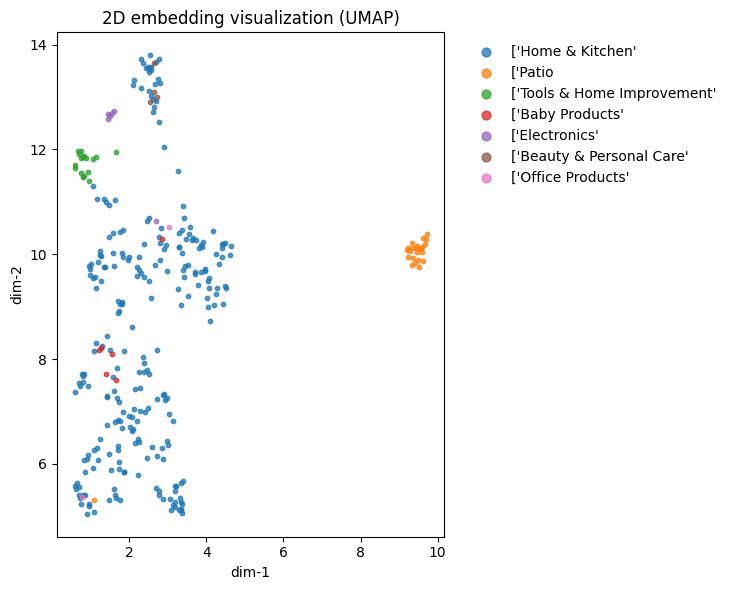

In [30]:
# ===== Optional 2D embedding visualization (UMAP preferred, else PCA) =====
import numpy as np
import matplotlib.pyplot as plt

# Try UMAP; if not available, fallback to PCA (no extra install needed)
try:
    from umap import UMAP
    reducer = UMAP(n_components=2, random_state=SEED, n_neighbors=20, min_dist=0.1)
    method = "UMAP"
except Exception:
    from sklearn.decomposition import PCA
    reducer = PCA(n_components=2, random_state=SEED)
    method = "PCA"

# Sample for speed/clarity on large datasets
max_points = 1500
if len(df) > max_points:
    idxs = np.random.default_rng(SEED).choice(len(df), size=max_points, replace=False)
else:
    idxs = np.arange(len(df))

X = emb[idxs]                      # (N, D) embedding matrix from earlier cells
cats = df.iloc[idxs]["category_main"].fillna("").astype(str).values

# Fit transform
pts2d = reducer.fit_transform(X)

# Plot top categories (others grouped)
topk = 8
unique, counts = np.unique(cats, return_counts=True)
order = np.argsort(-counts)
top_labels = set(unique[order][:topk])

plt.figure(figsize=(7.5, 6))
for label in unique[order]:
    mask = (cats == label)
    if label in top_labels:
        plt.scatter(pts2d[mask, 0], pts2d[mask, 1], s=10, alpha=0.75, label=label)
    else:
        # draw "other" lightly once
        pass
# Draw "other" points in a light gray
other_mask = ~np.isin(cats, list(top_labels))
if other_mask.any():
    plt.scatter(pts2d[other_mask, 0], pts2d[other_mask, 1], s=8, alpha=0.25, label="other", edgecolors='none')

plt.title(f"2D embedding visualization ({method})")
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.legend(markerscale=2, bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()
